In [1]:
# Read data
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)

In [2]:
# Read data description: https://archive.ics.uci.edu/ml/datasets/wine
# Columns names (1 - 13): Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids
# Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline
# Label column (column 0): Wine quality
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

# Nhắc lại các bước của thuật toán PCA:
1. Chuẩn hóa dữ liệu
2. Xây dựng ma trận hiệp phương sai từ dữ liệu đã được chuẩn hoá
3. Tìm các vectơ riêng, trị riêng của ma trận hiệp phương sai
4. Xây dựng tập trực chuẩn từ tập hợp các vecto trên
5. Sắp xếp các trị riêng theo chiều tăng dần
6. Chọn k vectơ riêng đầu tiên ứng với k trị riêng đầu tiên trong bộ trị riêng có thứ tự ở bước trên (k << d)
7. Xây dựng ma trận chiếu W từ các vectơ riêng trên
8. Tìm hình chiếu Y của ma trận dữ liệu X trong không gian mới sinh bởi ma trận W, Y = WX

In [4]:
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()

X_std = sc.fit_transform(X)


In [5]:
(X - X.mean(axis = 0))/X.std(axis = 0, ddof = 0)

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [6]:
# sklearn dùng phương sai không hiệu chỉnh!
(X_std == (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 0)).all()

True

In [7]:
# Ta sẽ dùng phương sai có hiệu chỉnh
# Xem thêm: https://numpy.org/doc/stable/reference/generated/numpy.std.html

X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def covariance(X):
    '''
        Tính ma trận hiệp phương sai của dữ liệu
        -----------------------
        Các tham số:
            X: numpy-ndarray
                Ma trận dữ liệu, trong đó mỗi dòng là một quan sát
        -----------------------
        Trả về: numpy-ndarray
            Ma trận hiệp phương sai
    '''
    return np.cov(X.T)
    # Có thể dùng thay thế: return np.cov(X, rowvar = False)
    # Tham số rowvar được mặc định để là True, khi đó mỗi dòng của ma trận là một biến, mỗi cột là một quan sát
    # Xem thêm: https://numpy.org/doc/stable/reference/generated/numpy.cov.html

def calculateEigen(Sigma):
    '''
        Tính trị riêng và vectơ riêng của ma trận đối xứng
        -----------------------
        Các tham số:
            Sigma: numpy-ndarray
                Ma trận đối xứng cần tính
        -----------------------
        Trả về: list of tuples
            Một danh sách các bộ có thứ tự, trong đó mỗi bộ gồm (trị riêng, vectơ riêng ứng với trị riêng đó)
    '''
    return np.linalg.eig(Sigma)
    # Nguyên nhân ta dùng np.linalg.eigh thay vì np.linalg.eig đã được nói trong slide 

def PCAMethod(X, k = None):
    '''
        Thực hiện thuật toán PCA
        -----------------------
        Các tham số:
            X: numpy-ndarray
                Ma trận dữ liệu trong đó mỗi dòng là một quan sát
            k: int, default: None
                Số vectơ thành phần chính
        -----------------------
        Trả về:
            Kết quả của thuật toán PCA, là một danh sách các bộ có thứ tự, 
            trong đó mỗi bộ gồm (trị riêng, vectơ riêng ứng với trị riêng đó).
            
            Nếu tham số k là None thì trả về toàn bộ danh sách, ngược lại, ta chỉ lấy k phần tử đầu tiên
    '''
    
    # 1) Tính ma trận hiệp phương sai mẫu
    Sigma = covariance(X)
    # 2) Tìm trị riêng, vectơ riêng của ma trận hiệp phương sai mẫu
    eigenvals, eigenvecs = calculateEigen(Sigma)
    print(eigenvals)
    # 3) Sắp xếp cặp (trị riêng, vectơ riêng) với trị riêng theo chiều giảm dần
    eigenpairs = [(abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
    eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

    if k is None:
        return eigenpairs
    else:
        return eigenpairs[:k]

def findNumPC(eigenpairs, thres = 0.95):
    '''
        Tìm số lượng vectơ thành phần chính
        -----------------------
        Các tham số:
            eigenpairs: list-like
                Cặp (trị riêng, vectơ riêng) có từ thuật toán PCA
            thres: float, default = 0.95
                Ngưỡng thông tin ta muốn giữ lại từ dữ liệu (mặc định ta giữ lại 95% dữ liệu ban đầu)
        -----------------------
        Trả về:
            Số lượng vectơ thành phần chính
    '''
    # 1) Lấy ra các trị riêng
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    print(eigenvals)
    eigenvals = np.array(eigenvals)
    print(eigenvals)
    # 2) Tính tổng dồn các trị riêng
    cumsum = np.cumsum(eigenvals)
    # 3) Tính phần trăm
    cumsum /= cumsum[-1]

    # 4) Lặp từng phần tử trong cumsum, khi nào phần trăm cộng dồn vừa đến ngưỡng thì ta dừng
    for i, val in enumerate(cumsum):
        if val >= thres:
            return i + 1

def construct_W(eigenpairs):
    '''
        Xây dựng ma trận chiếu W từ cặp (trị riêng, vectơ riêng) có được từ thuật toán PCA
        -----------------------
        Các tham số:
            eigenpairs: list-like
                Danh sách các cặp (trị riêng, vectơ riêng) có từ thuật toán PCA
        -----------------------
        Trả về: numpy-ndarray
            Ma trận phép chiếu W trong đó mỗi dòng là một vectơ riêng
    '''
    eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
    W = np.array([e.T for e in eigenvecs])
    return W

def screeplot(eigenpairs):
    '''
        Vẽ đồ thị scree
        -----------------------
        Tham số:
            eigenpairs: list-like
                Cặp (trị riêng, vectơ riêng) có từ thuật toán PCA
        -----------------------
        Trả về: None
            Vễ đồ thị scree biểu diễn lượng thông tin có được ứng với mỗi vectơ riêng
    '''
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 8), sharex = True)
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    cumsum = np.cumsum(eigenvals)
    cumsum /= cumsum[-1]

    axes[0].plot(range(len(eigenvals)), eigenvals, marker = '.', color = 'b', label = 'Eigenvalue')
    axes[1].plot(range(len(cumsum)), cumsum, marker = '.', color = 'r', label = 'Cumulative propotion')

    axes[0].legend()
    axes[1].legend()
    plt.show()

In [9]:
eigenpairs = PCAMethod(X_std)

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.10337794 0.16877023 0.28887994 0.22578864
 0.25090248]


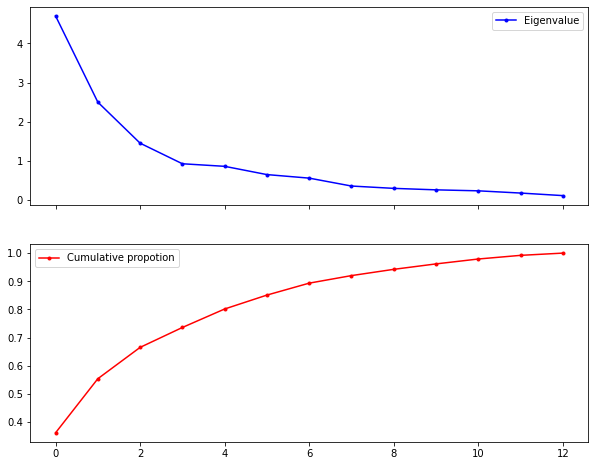

In [10]:
# Nhận xét: Đồ thị scree khá thoải, dẫn đến việc ta cần nhiều trị riêng để giữ nhiều thông tin của dữ liệu
screeplot(eigenpairs)

In [11]:
# Kiểm chứng sự trực chuẩn của họ các vectơ riêng
# Sự trực chuẩn này có được là nhờ sử dụng hàm np.linalg.eigh

eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]

for vec_x in eigenvecs:
    for vec_y in eigenvecs:
        print(vec_x.T.dot(vec_y))
    print('-' * 50)

0.9999999999999998
8.326672684688674e-17
3.469446951953614e-17
-1.8041124150158794e-16
-1.3183898417423734e-16
-2.7755575615628914e-17
-2.636779683484747e-16
-2.983724378680108e-16
-1.1102230246251565e-16
-2.914335439641036e-16
1.6653345369377348e-16
-2.220446049250313e-16
2.220446049250313e-16
--------------------------------------------------
8.326672684688674e-17
0.9999999999999998
-1.942890293094024e-16
3.2612801348363973e-16
-3.2439329000766293e-16
1.97758476261356e-16
-2.0816681711721685e-16
-2.7755575615628914e-17
-2.220446049250313e-16
1.249000902703301e-16
-2.498001805406602e-16
-8.326672684688674e-17
1.1449174941446927e-16
--------------------------------------------------
3.469446951953614e-17
-1.942890293094024e-16
1.0000000000000002
1.6653345369377348e-16
-1.942890293094024e-16
3.677613769070831e-16
-1.1102230246251565e-16
-4.85722573273506e-16
-1.1796119636642288e-16
2.0816681711721685e-16
-5.134781488891349e-16
1.3877787807814457e-16
0.0
---------------------------------

In [12]:
# Cần 10 vectơ chính ta mới có thể giữ lại 95% thông tin của dữ liệu
findNumPC(eigenpairs, thres = 0.95)

[4.705850252990425, 2.496973733411161, 1.4460719697124977, 0.9189739237528225, 0.8532281783543179, 0.6416570314989337, 0.5510283119410323, 0.348497363289252, 0.2888799426226624, 0.25090248221273026, 0.22578863969868884, 0.1687702348285476, 0.10337793568692862]
[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]


10

In [13]:
import numpy as np
a = np.array([0,1,2,3,4,5,6,7,8,9])
np.cumsum(a)[2]


3

In [14]:
# Ta chỉ giữ lại 66% dữ liệu khi lấy 2 vectơ chính
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals)
print(eigenvals)
# 2) Tính tổng dồn các trị riêng
cumsum = np.cumsum(eigenvals)
# 3) Tính phần trăm
cumsum /= cumsum[-1]

cumsum[2]

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.28887994 0.25090248 0.22578864 0.16877023
 0.10337794]


0.6652996889318527

In [15]:
# Để dễ trực quan, ta sẽ dùng 2 vectơ, tức chỉ giữ lại 66% thông tin của dữ liệu
eigenpairs = PCAMethod(X_std, k = 2)
W = construct_W(eigenpairs)

[4.70585025 2.49697373 1.44607197 0.91897392 0.85322818 0.64165703
 0.55102831 0.34849736 0.10337794 0.16877023 0.28887994 0.22578864
 0.25090248]


In [16]:
X_pca = W.dot(X_std.T)
X_pca = X_pca.T

In [17]:
X_pca.shape

(178, 2)

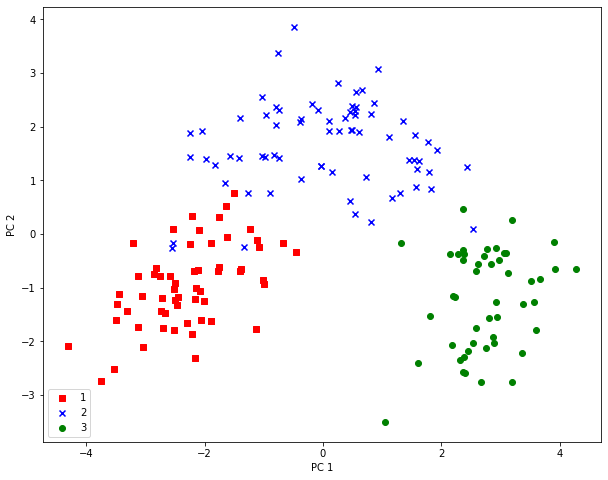

In [18]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig, ax = plt.subplots(figsize = (10, 8))

for l, c, m in zip(np.unique(y), colors, markers):
    ax.scatter(X_pca[y == l, 0], X_pca[y == l, 1], c = c, label = l, marker = m)
ax.set(xlabel = 'PC 1', ylabel = 'PC 2')
plt.legend(loc='lower left')
plt.show()

# So sánh với hàm thư viện

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

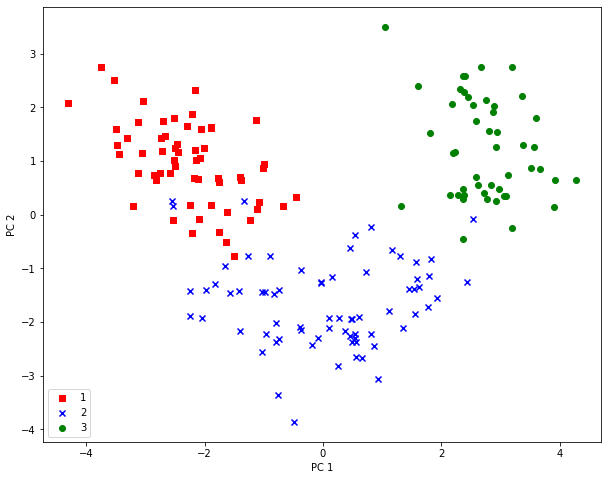

In [20]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

fig, ax = plt.subplots(figsize = (10, 8))

for l, c, m in zip(np.unique(y), colors, markers):
    ax.scatter(X_pca[y == l, 0]*(-1), X_pca[y == l, 1]*(-1), c = c, label = l, marker = m)
ax.set(xlabel = 'PC 1', ylabel = 'PC 2')
plt.legend(loc='lower left')
plt.show()